In [121]:
import os
import sys
from collections import Counter, defaultdict

import json

import pdal

import laspy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [9]:
CWD = os.getcwd()
PATH_TO_LAZ = os.path.join(
    CWD,
    "data",
    "raw",
    "laz"
)

files = os.listdir(PATH_TO_LAZ)

In [140]:
prefix3 = [fname[:3] for fname in files]
count3 = Counter(prefix3)

prefix7 = [fname[:7] for fname in files]
count7 = Counter(prefix7)

prefix13 = [fname[:13] for fname in files]
count13 = Counter(prefix13)

print(len(count3))
print(len(count7))
print(len(count13))
# print("Counts by first 3 letters:")
# for k, v in count13.most_common():
#     print(f"{k}: {v}")

40
75
124


In [141]:
# Group files by prefix7

grouped_files = defaultdict(list)
for fname in files:
    prefix = fname[:7]
    grouped_files[prefix].append(fname)

# Write each group to a separate .txt file
out_dir = os.path.join(CWD, "prefix7_filelists")
os.makedirs(out_dir, exist_ok=True)

for prefix, fnames in grouped_files.items():
    list_path = os.path.join(out_dir, f"{prefix}_files.txt")
    with open(list_path, "w") as f:
        for name in fnames:
            f.write(name + "\n")

print(f"Saved {len(grouped_files)} files, one for each prefix7.")

Saved 75 files, one for each prefix7.


In [143]:
metafile_path = os.path.join(CWD, "prefix7_metafile.txt")
with open(metafile_path, "w") as meta_f:
    for prefix, fnames in grouped_files.items():
        # pick one file per prefix7 group (the first one)
        single_file = fnames[0]
        meta_f.write(f"{single_file}\n")
        # # optionally, use the full path:
        # full_path = os.path.join(PATH_TO_LAZ, single_file)
        # # Write: prefix7, file name, full path (customize columns as you like)
        # meta_f.write(f"{prefix}\t{single_file}\t{full_path}\n")

print(f"Metafile saved to {metafile_path}")

Metafile saved to /Users/jamesbyers/code/github/Kaggle/openai_to_z/prefix7_metafile.txt


In [27]:
# Helper function to make a defaultdict of defaultdicts recursively
def tree():
    return defaultdict(tree)

def add_to_tree(t, keys, value):
    for key in keys[:-1]:
        t = t[key]
    t[keys[-1]] = value

def grow_tree(files):

    root = tree()
    for fname in files:
        parts = fname.split('_')
        add_to_tree(root, parts, fname)
    return root

def dictify(d):
    if isinstance(d, defaultdict):
        return {k: dictify(v) for k, v in d.items()}
    else:
        return d
    
root = grow_tree(files)
root_dict = dictify(root)

# print(json.dumps(root_dict, indent=2))

In [99]:
def get_all_filepaths(d):
    paths = []
    for v in d.values():
        if isinstance(v, dict):
            paths.extend(get_all_filepaths(v))
        else:
            real_path = os.path.join(
                PATH_TO_LAZ,
                v)
            paths.append(real_path)  # This is the filename string
    return paths

def laspy_point_density(path):
    las = laspy.read(path)
    classifications = las.classification
    xs = las.x
    ys = las.y

    # Compute area from bounds
    minx, maxx = np.min(xs), np.max(xs)
    miny, maxy = np.min(ys), np.max(ys)
    area = (maxx - minx) * (maxy - miny)

    total_points = len(xs)
    ground_points = np.sum(classifications == 2)
    density_total = total_points / area if area > 0 else np.nan
    density_ground = ground_points / area if area > 0 else np.nan
    ground_fraction = ground_points / total_points if total_points > 0 else np.nan

    # If you want class histogram:
    classes, counts = np.unique(classifications, return_counts=True)
    hist = dict(zip(classes.astype(str), counts))

    return {
        "file": path,
        "total_points": total_points,
        "ground_points": ground_points,
        "area_m2": area,
        "density_total_per_m2": density_total,
        "density_ground_per_m2": density_ground,
        "ground_fraction": ground_fraction,
        "classification_histogram": hist
    }

def laspy_quality_stats(path):
    las = laspy.read(path)
    classes = las.classification
    xs, ys, zs = las.x, las.y, las.z

    # Area (in m^2)
    minx, maxx = xs.min(), xs.max()
    miny, maxy = ys.min(), ys.max()
    area_m2 = max(0, (maxx - minx) * (maxy - miny))
    area_km2 = area_m2 / 1e6

    total_points = len(xs)
    ground_points = int(np.sum(classes == 2))
    density_total = total_points / area_m2 if area_m2 > 0 else np.nan
    density_ground = ground_points / area_m2 if area_m2 > 0 else np.nan
    ground_fraction = ground_points / total_points if total_points > 0 else np.nan

    # Classification histogram
    cls_vals, cls_counts = np.unique(classes, return_counts=True)
    classification_hist = {int(cl): int(co) for cl, co in zip(cls_vals, cls_counts)}

    # Return numbers
    ret_num_vals, ret_num_counts = np.unique(las.return_number, return_counts=True)
    num_ret_vals, num_ret_counts = np.unique(las.number_of_returns, return_counts=True)
    returns_hist = {int(label): int(ct) for label, ct in zip(ret_num_vals, ret_num_counts)}
    num_returns_hist = {int(label): int(ct) for label, ct in zip(num_ret_vals, num_ret_counts)}

    # Withheld/Synthetic points
    n_withheld = int(np.count_nonzero(las.withheld)) if hasattr(las, 'withheld') else 0
    n_synthetic = int(np.count_nonzero(las.synthetic)) if hasattr(las, 'synthetic') else 0

    # Z outlier stats
    z_qs = np.percentile(zs, [0, 1, 5, 50, 95, 99, 100])

    # Intensity
    intensity_qs = np.percentile(las.intensity, [0, 25, 50, 75, 100])

    # Scan angle
    scan_angle_abs = np.abs(las.scan_angle_rank)
    scan_angle_stats = {
        'mean': np.mean(scan_angle_abs),
        'max': np.max(scan_angle_abs),
        'min': np.min(scan_angle_abs),
        'p95': np.percentile(scan_angle_abs, 95)
    }

    return {
        "file": path,
        "total_points": total_points,
        "ground_points": ground_points,
        "area_m2": area_m2,
        "area_km2": area_km2,
        "density_total_per_m2": density_total,
        "density_ground_per_m2": density_ground,
        "ground_fraction": ground_fraction,
        "classification_histogram": classification_hist,
        "returns_histogram": returns_hist,
        "number_of_returns_histogram": num_returns_hist,
        "n_withheld": n_withheld,
        "n_synthetic": n_synthetic,
        "z_quantiles": z_qs,
        "intensity_quantiles": intensity_qs,
        "scan_angle_stats": scan_angle_stats
    }

In [100]:
def print_metadata(info):
    print(f"\nFile: {info['file']}")
    print(f"{'-'*50}")
    print(f"{'Total points:':20} {info['total_points']:.2e}")
    print(f"{'Ground points:':20} {info['ground_points']:.2e}")
    print(f"{'Area:':20} {info['area_m2'] / 1e6:.2f} km²")
    print(f"{'Total density:':20} {info['density_total_per_m2']:.2f} /m")
    print(f"{'Ground density:':20} {info['density_ground_per_m2']:.2f} /m²")
    print(f"{'Ground fraction:':20} {info['ground_fraction']*100:.2f} %")
    
    if info.get('classification_histogram'):
        print("\nClassification histogram:")
        # Sort by count descending for nicer output
        items = sorted(
            info['classification_histogram'].items(),
            key=lambda t: t[1], reverse=True
        )
        total = sum(info['classification_histogram'].values())
        print(f"{'Class':>8} {'Count':>12} {'Percent':>10}")
        print("-" * 32)
        for cl, cnt in items:
            percent = cnt / total * 100 if total else 0.0
            print(f"{cl:>8} {cnt:12,.2e} {percent:9.2f}%")

def print_quality_stats(stat):
    print(f"\nFile: {stat['file']}")
    print(f"{'-'*60}")
    print(f"{'Total points:':25} {stat['total_points']:.2e}")
    print(f"{'Ground points:':25} {stat['ground_points']:.2e}")
    print(f"{'Area:':25} {stat['area_km2']:.2f} km²")
    print(f"{'Total density:':25} {stat['density_total_per_m2']:.2f} /m²")
    print(f"{'Ground density:':25} {stat['density_ground_per_m2']:.2f} /m²")
    print(f"{'Ground fraction:':25} {stat['ground_fraction']*100:.2f} %")

    print(f"{'Withheld points:':25} {stat['n_withheld']}")
    print(f"{'Synthetic points:':25} {stat['n_synthetic']}")

    print("\nClassification histogram:")
    total = sum(stat['classification_histogram'].values())
    print(f"{'Class':>8} {'Count':>12} {'%':>8}")
    print("-" * 32)
    for cl, cnt in sorted(stat['classification_histogram'].items()):
        percent = cnt / total * 100 if total else 0.0
        print(f"{cl:>8} {cnt:12,.2e} {percent:7.2f}%")

    print("\nReturn Number histogram:")
    for label, ct in sorted(stat['returns_histogram'].items()):
        print(f"  Return {label}: {ct:,}")

    print("Number of returns per pulse histogram:")
    for label, ct in sorted(stat['number_of_returns_histogram'].items()):
        print(f"  {label} returns: {ct:,}")

    print(f"\nZ (elevation) quantiles (min, 1%, 5%, median, 95%, 99%, max):")
    print("  " + ", ".join(f"{z:.2f}" for z in stat['z_quantiles']))

    print(f"\nIntensity quantiles (min, Q1, median, Q3, max):")
    print("  " + ", ".join(f"{intsty:.2f}" for intsty in stat['intensity_quantiles']))

    print("\nScan angle stats (deg, abs):")
    for k, v in stat['scan_angle_stats'].items():
        print(f"  {k:>6}: {v:.2f}")

In [90]:
all_file_paths = get_all_filepaths(root_dict)  # Replace with your dict
# print(all_file_paths)

info = laspy_point_density(all_file_paths[0])
print_metadata(info)


File: /Users/jamesbyers/code/github/Kaggle/openai_to_z/data/raw/laz/JAM_A02_2011_laz_4.laz
--------------------------------------------------
Total points:        1.73e+07
Ground points:       4.23e+05
Area:                0.67 km²
Total density:       25.76 /m
Ground density:      0.63 /m²
Ground fraction:     2.45 %

Classification histogram:
   Class        Count    Percent
--------------------------------
       5     1.49e+07     86.14%
       4     1.04e+06      5.98%
       3     9.40e+05      5.43%
       2     4.23e+05      2.45%


In [101]:
all_file_paths = get_all_filepaths(root_dict)  # Replace with your dict
# print(all_file_paths)

info = laspy_quality_stats(all_file_paths[0])
print_quality_stats(info)


File: /Users/jamesbyers/code/github/Kaggle/openai_to_z/data/raw/laz/JAM_A02_2011_laz_4.laz
------------------------------------------------------------
Total points:             1.73e+07
Ground points:            4.23e+05
Area:                     0.67 km²
Total density:            25.76 /m²
Ground density:           0.63 /m²
Ground fraction:          2.45 %
Withheld points:          0
Synthetic points:         0

Classification histogram:
   Class        Count        %
--------------------------------
       2     4.23e+05    2.45%
       3     9.40e+05    5.43%
       4     1.04e+06    5.98%
       5     1.49e+07   86.14%

Return Number histogram:
  Return 1: 10,556,158
  Return 2: 6,740,147
Number of returns per pulse histogram:
  1 returns: 5,271,672
  2 returns: 10,574,150
  3 returns: 1,450,483

Z (elevation) quantiles (min, 1%, 5%, median, 95%, 99%, max):
  90.81, 91.76, 92.54, 111.23, 129.20, 135.15, 153.41

Intensity quantiles (min, Q1, median, Q3, max):
  0.00, 34.00, 111.00

In [94]:
results = []
for path in all_file_paths[:1]:
    try:
        stat = laspy_point_density(path)
        print_metadata(stat)
    except Exception as e:
        print(f"Failed for {path}: {e}")


File: /Users/jamesbyers/code/github/Kaggle/openai_to_z/data/raw/laz/JAM_A02_2011_laz_4.laz
--------------------------------------------------
Total points:        1.73e+07
Ground points:       4.23e+05
Area:                0.67 km²
Total density:       25.76 /m
Ground density:      0.63 /m²
Ground fraction:     2.45 %

Classification histogram:
   Class        Count    Percent
--------------------------------
       5     1.49e+07     86.14%
       4     1.04e+06      5.98%
       3     9.40e+05      5.43%
       2     4.23e+05      2.45%


In [118]:
def get_class_from_filename(fname):
    # This gets e.g. 'JAM_A02' from 'JAM_A02_2011_laz_4.laz'
    return '_'.join(fname.split('_')[:2])

SAVE_CSV = "processed_metadata.csv"

# Try to load previous progress
if os.path.exists(SAVE_CSV):
    df = pd.read_csv(SAVE_CSV)
    if 'filename' in df.columns:
        done_files = set(df['filename'])
        rows = df.to_dict('records')
    else:
        done_files = set()
        rows = []
else:
    done_files = set()
    rows = []

print(f"Starting with {len(done_files)} files already done.")

# Main processing loop
for i, path in enumerate(tqdm(all_file_paths, desc="Processing .laz files")):
    fname = os.path.basename(path)
    if fname in done_files:
        continue
    try:
        meta = laspy_quality_stats(path)
        meta['class'] = get_class_from_filename(fname)
        meta['filename'] = fname
        meta['mean_scan_angle'] = meta['scan_angle_stats']['mean']
        meta['max_scan_angle'] = meta['scan_angle_stats']['max']
        rows.append(meta)
        done_files.add(fname)
    except Exception as e:
        tqdm.write(f"Failed for {path}: {e}")

    # Every 100, save progress
    if (len(rows) % 100 == 0) and (len(rows) > 0):
        df = pd.DataFrame(rows)
        df.to_csv(SAVE_CSV, index=False)
        tqdm.write(f"Saved progress ({len(rows)} files) to {SAVE_CSV}")

# Save at the end (in case not a multiple of 100)
df = pd.DataFrame(rows)
df.to_csv(SAVE_CSV, index=False)
tqdm.write(f"Final save: ({len(rows)} files) to {SAVE_CSV}")

# Now aggregate by class as before
agg_fields = [
    'density_total_per_m2',
    'density_ground_per_m2',
    'ground_fraction',
    'area_km2',
    'mean_scan_angle',
    'max_scan_angle',
]
class_summary = df.groupby('class')[agg_fields].agg(['mean', 'std', 'min', 'max', 'count']).sort_index()
print(class_summary)
class_summary.to_csv('class_metadata_summary.csv')

# Print a few summarized classes for inspection
for class_name, group in df.groupby('class'):
    print(f"\n=== {class_name} ===")
    print(f"  Files: {len(group)}")
    print(f"  Mean ground density: {group['density_ground_per_m2'].mean():.2f} /m²")
    print(f"  Mean ground fraction: {group['ground_fraction'].mean()*100:.2f} %")
    print(f"  Scan angle mean: {group['mean_scan_angle'].mean():.1f}°")
    # You can add more printing here as needed

Starting with 0 files already done.


Processing .laz files:   3%|▎         | 100/3154 [02:17<1:07:35,  1.33s/it]

Saved progress (100 files) to processed_metadata.csv


Processing .laz files:   6%|▋         | 200/3154 [04:37<1:19:53,  1.62s/it]

Saved progress (200 files) to processed_metadata.csv


Processing .laz files:  10%|▉         | 301/3154 [06:56<41:48,  1.14it/s]  

Saved progress (300 files) to processed_metadata.csv


Processing .laz files:  13%|█▎        | 400/3154 [08:41<20:31,  2.24it/s]  

Saved progress (400 files) to processed_metadata.csv


Processing .laz files:  14%|█▍        | 441/3154 [09:22<1:19:45,  1.76s/it]

Failed for /Users/jamesbyers/code/github/Kaggle/openai_to_z/data/raw/laz/FST_A01a_2015_laz_5.laz: IoError: failed to fill whole buffer


Processing .laz files:  16%|█▌        | 500/3154 [10:03<11:32,  3.83it/s]  

Saved progress (500 files) to processed_metadata.csv


Processing .laz files:  19%|█▉        | 601/3154 [10:21<04:47,  8.90it/s]

Saved progress (600 files) to processed_metadata.csv


Processing .laz files:  22%|██▏       | 702/3154 [10:39<06:33,  6.23it/s]

Saved progress (700 files) to processed_metadata.csv


Processing .laz files:  25%|██▌       | 802/3154 [10:58<06:23,  6.13it/s]

Saved progress (800 files) to processed_metadata.csv


Processing .laz files:  29%|██▊       | 902/3154 [11:25<05:19,  7.05it/s]

Saved progress (900 files) to processed_metadata.csv


Processing .laz files:  32%|███▏      | 1001/3154 [11:55<19:26,  1.85it/s]

Saved progress (1000 files) to processed_metadata.csv


Processing .laz files:  35%|███▍      | 1101/3154 [13:44<12:49,  2.67it/s]  

Saved progress (1100 files) to processed_metadata.csv


Processing .laz files:  38%|███▊      | 1201/3154 [14:14<07:41,  4.23it/s]

Saved progress (1200 files) to processed_metadata.csv


Processing .laz files:  41%|████      | 1301/3154 [14:49<09:30,  3.25it/s]

Saved progress (1300 files) to processed_metadata.csv


Processing .laz files:  44%|████▍     | 1401/3154 [15:31<11:17,  2.59it/s]

Saved progress (1400 files) to processed_metadata.csv


Processing .laz files:  48%|████▊     | 1501/3154 [17:44<52:31,  1.91s/it]  

Saved progress (1500 files) to processed_metadata.csv


Processing .laz files:  51%|█████     | 1601/3154 [20:26<59:02,  2.28s/it]  

Saved progress (1600 files) to processed_metadata.csv


Processing .laz files:  54%|█████▍    | 1701/3154 [22:06<12:12,  1.98it/s]

Saved progress (1700 files) to processed_metadata.csv


Processing .laz files:  57%|█████▋    | 1801/3154 [22:53<14:12,  1.59it/s]

Saved progress (1800 files) to processed_metadata.csv


Processing .laz files:  60%|██████    | 1901/3154 [23:36<09:06,  2.29it/s]

Saved progress (1900 files) to processed_metadata.csv


Processing .laz files:  61%|██████    | 1914/3154 [23:40<05:22,  3.85it/s]

Failed for /Users/jamesbyers/code/github/Kaggle/openai_to_z/data/raw/laz/ST2_A01_2016_laz_12.laz: IoError: failed to fill whole buffer


Processing .laz files:  63%|██████▎   | 2002/3154 [24:42<04:46,  4.02it/s]

Saved progress (2000 files) to processed_metadata.csv


Processing .laz files:  67%|██████▋   | 2102/3154 [25:12<04:50,  3.62it/s]

Saved progress (2100 files) to processed_metadata.csv


Processing .laz files:  70%|██████▉   | 2202/3154 [25:48<09:52,  1.61it/s]

Saved progress (2200 files) to processed_metadata.csv


Processing .laz files:  73%|███████▎  | 2302/3154 [26:23<04:30,  3.15it/s]

Saved progress (2300 files) to processed_metadata.csv


Processing .laz files:  76%|███████▌  | 2402/3154 [26:54<05:07,  2.44it/s]

Saved progress (2400 files) to processed_metadata.csv


Processing .laz files:  79%|███████▉  | 2502/3154 [29:53<21:46,  2.00s/it]

Saved progress (2500 files) to processed_metadata.csv


Processing .laz files:  82%|████████▏ | 2602/3154 [32:29<06:10,  1.49it/s]

Saved progress (2600 files) to processed_metadata.csv


Processing .laz files:  86%|████████▌ | 2702/3154 [33:16<03:34,  2.11it/s]

Saved progress (2700 files) to processed_metadata.csv


Processing .laz files:  89%|████████▉ | 2802/3154 [35:29<02:18,  2.55it/s]

Saved progress (2800 files) to processed_metadata.csv


Processing .laz files:  92%|█████████▏| 2902/3154 [37:07<09:47,  2.33s/it]

Saved progress (2900 files) to processed_metadata.csv


Processing .laz files:  95%|█████████▌| 3002/3154 [39:17<03:15,  1.29s/it]

Saved progress (3000 files) to processed_metadata.csv


Processing .laz files:  96%|█████████▌| 3019/3154 [39:51<06:06,  2.71s/it]

Failed for /Users/jamesbyers/code/github/Kaggle/openai_to_z/data/raw/laz/.DS_Store: Invalid file signature "b'\x00\x00\x00\x01'"


Processing .laz files:  98%|█████████▊| 3103/3154 [41:57<01:17,  1.52s/it]

Saved progress (3100 files) to processed_metadata.csv


Processing .laz files: 100%|█████████▉| 3150/3154 [43:11<00:06,  1.53s/it]

Failed for /Users/jamesbyers/code/github/Kaggle/openai_to_z/data/raw/laz/cms_brazil_lidar_tile_inventory.kmz: Invalid file signature "b'PK\x03\x04'"


Processing .laz files: 100%|██████████| 3154/3154 [43:16<00:00,  1.21it/s]


Final save: (3150 files) to processed_metadata.csv
                          density_total_per_m2                        \
                                          mean        std        min   
class                                                                  
ANA_A01                              23.150292   5.222205  14.996306   
AND_A01                              27.331936   9.492456  12.788095   
ANTL5770C8970_cleaned.laz            21.705440        NaN  21.705440   
ANTL5770C8971_cleaned.laz            21.046605        NaN  21.046605   
ANTL5770C8972_cleaned.laz            21.430938        NaN  21.430938   
...                                        ...        ...        ...   
TAP_A02                              23.815558   6.298760  11.678064   
TAP_A03                              23.600478   8.300750   5.914404   
TAP_A04                              16.843576   8.266916   7.557388   
TAP_A05                              20.084647  10.652999   9.883269   
TAP_A06      

## Visualise LiDAR Quality
- density_total_per_m2
- density_ground_per_m2
- ground_fraction
- (optional) area_km2
- mean_scan_angle

In [124]:
# Individual tiles
df = pd.read_csv("lidar_metadata_full.csv")

# Class summary: for reference/useful but normally you'd plot df
class_summary = pd.read_csv("lidar_metadata_class_summary.csv", header=[0,1], index_col=0)

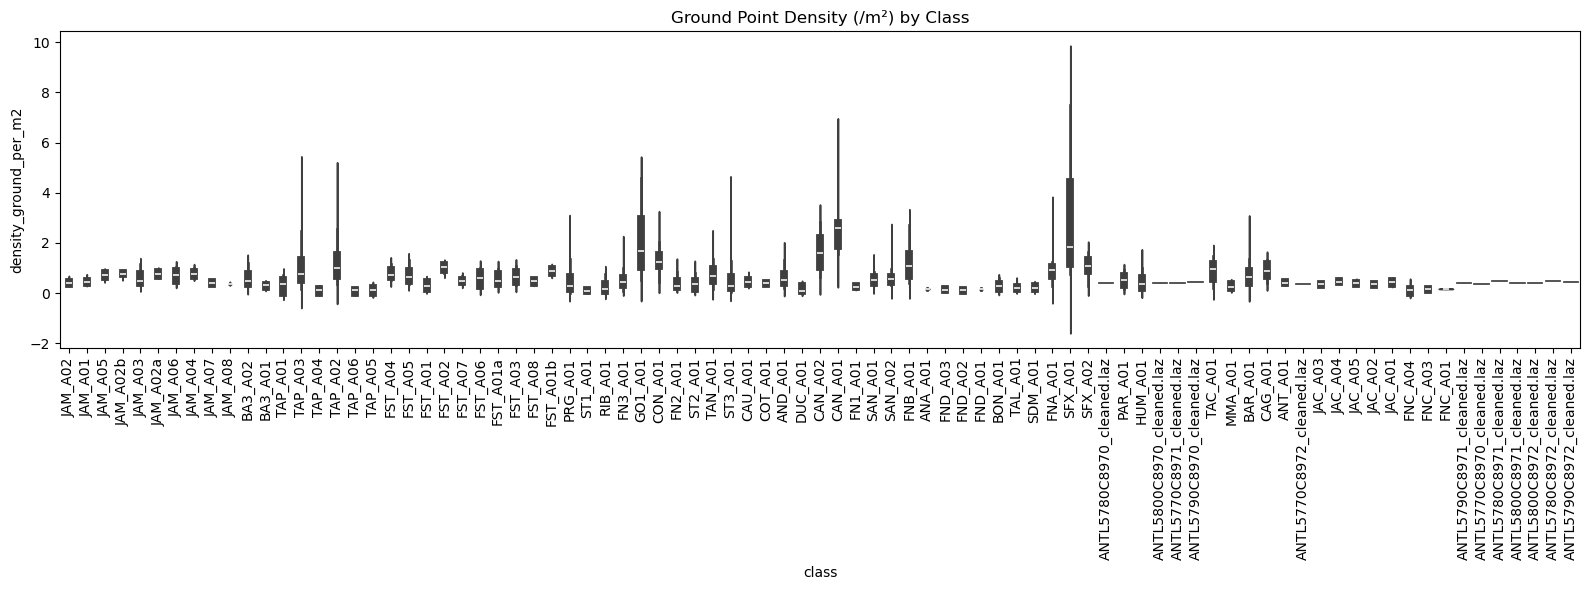

In [125]:
plt.figure(figsize=(16,6))
sns.violinplot(data=df, x="class", y="density_ground_per_m2", inner="box")
plt.xticks(rotation=90)
plt.title("Ground Point Density (/m²) by Class")
plt.tight_layout()
plt.show()

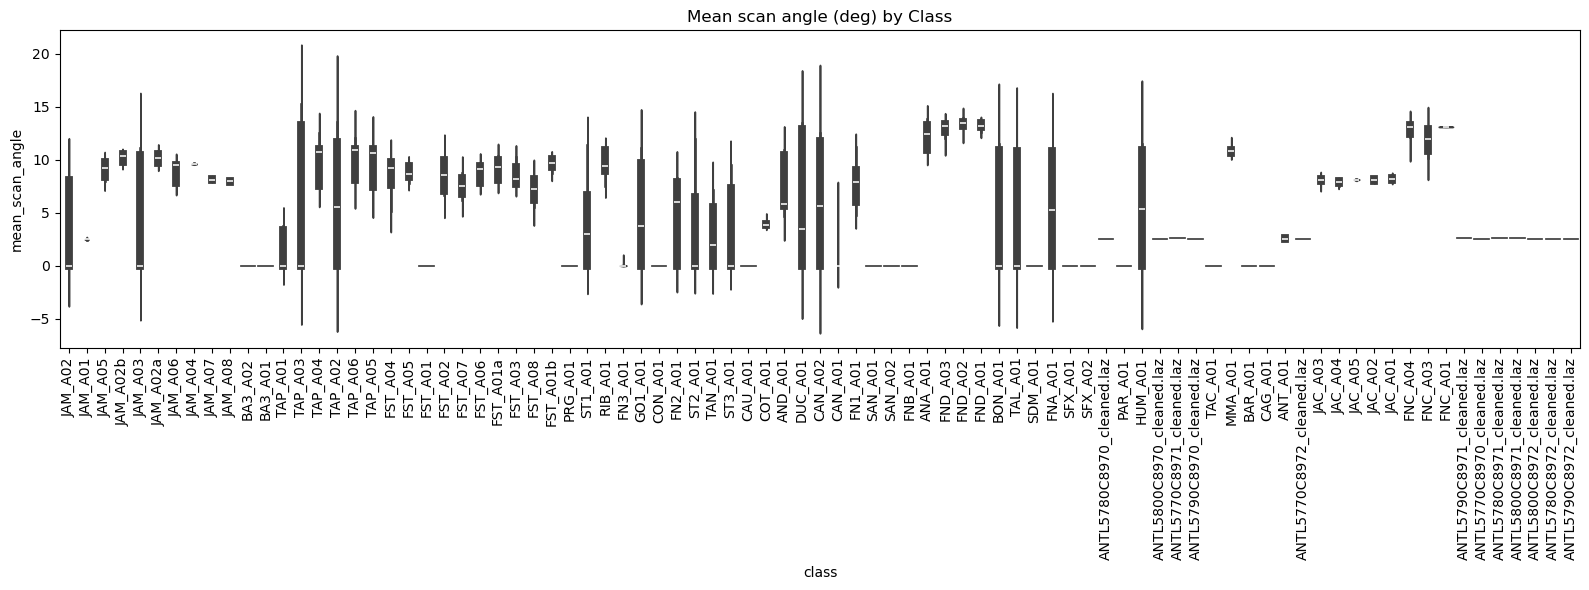

In [144]:
plt.figure(figsize=(16,6))
sns.violinplot(data=df, x="class", y="mean_scan_angle", inner="box")
plt.xticks(rotation=90)
plt.title("Mean scan angle (deg) by Class")
plt.tight_layout()
plt.show()

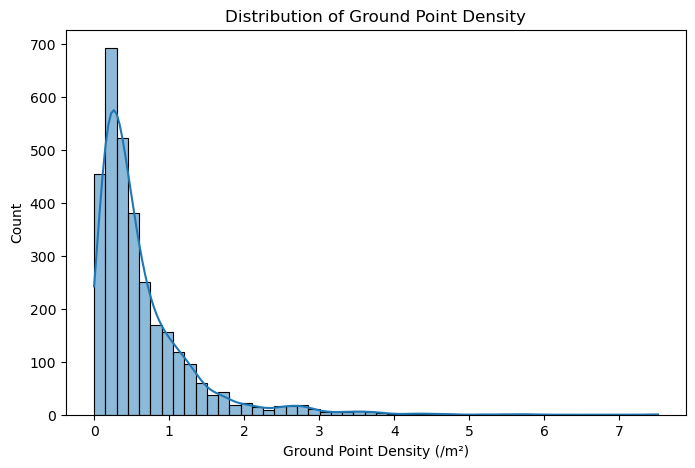

In [128]:
plt.figure(figsize=(8,5))
sns.histplot(df['density_ground_per_m2'], bins=50, kde=True)
plt.xlabel("Ground Point Density (/m²)")
plt.title("Distribution of Ground Point Density")
plt.show()

In [129]:
bad_classes = df.groupby("class")["density_ground_per_m2"].mean().sort_values().head(10)
print("Classes with lowest mean ground density:")
print(bad_classes)

Classes with lowest mean ground density:
class
TAP_A06    0.077211
ST1_A01    0.096721
TAP_A04    0.097298
FND_A02    0.103241
TAP_A05    0.122390
FNC_A04    0.123399
FND_A03    0.142180
FNC_A03    0.143467
DUC_A01    0.148912
FND_A01    0.159542
Name: density_ground_per_m2, dtype: float64


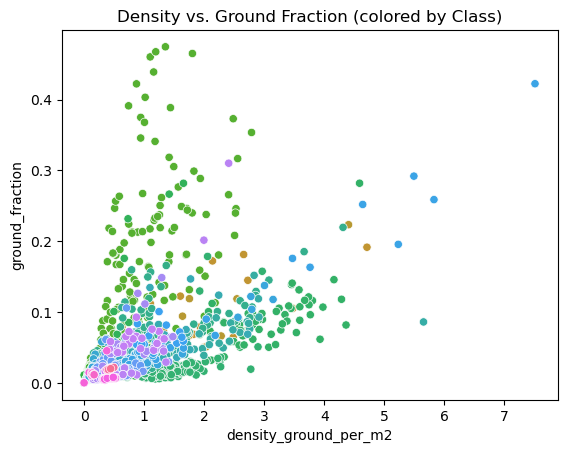

In [130]:
sns.scatterplot(data=df, x="density_ground_per_m2", y="ground_fraction", hue="class", legend=False)
plt.title("Density vs. Ground Fraction (colored by Class)")
plt.show()

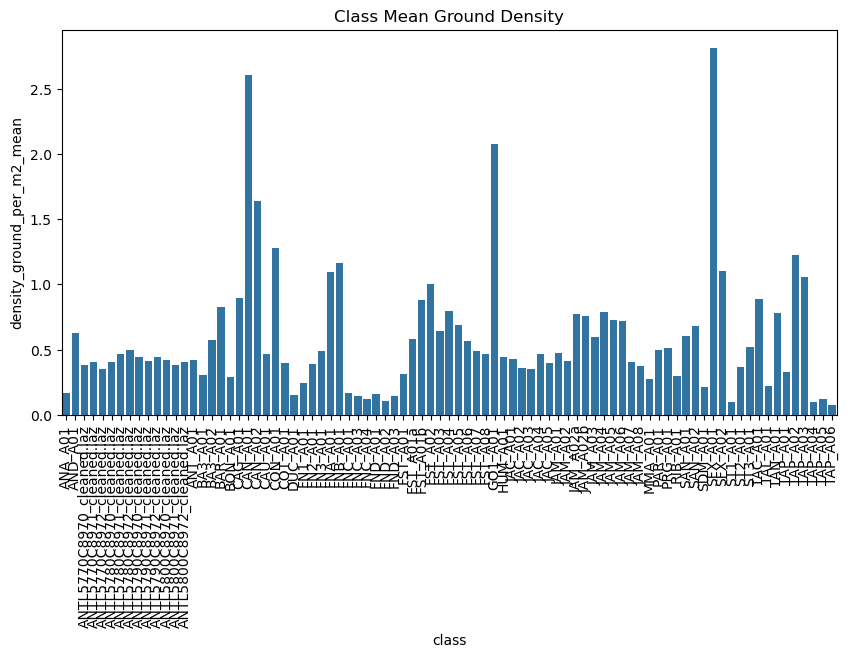

In [131]:
# The summary dataframe has multi-index columns: flatten for plotting
cls_sum = class_summary.copy()
cls_sum.columns = ['_'.join(col).strip() for col in cls_sum.columns.values]
cls_sum = cls_sum.reset_index()

plt.figure(figsize=(10,5))
sns.barplot(data=cls_sum, x="class", y="density_ground_per_m2_mean")
plt.xticks(rotation=90)
plt.title("Class Mean Ground Density")
plt.show()

In [133]:
outlier_tiles = df[df['density_ground_per_m2'] < 0.1]  # Example threshold
print(outlier_tiles[['filename', 'class', 'density_ground_per_m2', 'ground_fraction']])

                    filename    class  density_ground_per_m2  ground_fraction
203   TAP_A01_2008_laz_0.laz  TAP_A01               0.000000         0.000000
204   TAP_A01_2008_laz_1.laz  TAP_A01               0.000000         0.000000
205   TAP_A01_2008_laz_3.laz  TAP_A01               0.000000         0.000000
206   TAP_A01_2008_laz_2.laz  TAP_A01               0.000000         0.000000
207   TAP_A01_2008_14-03.laz  TAP_A01               0.000000         0.000000
...                      ...      ...                    ...              ...
2857  SDM_A01_2012_laz_1.laz  SDM_A01               0.073867         0.007712
2860  SDM_A01_2012_laz_6.laz  SDM_A01               0.085555         0.008594
3132  FNC_A04_2017_laz_0.laz  FNC_A04               0.084025         0.014367
3134  FNC_A04_2017_laz_3.laz  FNC_A04               0.000000         0.000000
3136  FNC_A04_2017_laz_5.laz  FNC_A04               0.000000         0.000000

[234 rows x 4 columns]


In [137]:
FOI = [
    "BON_A01_2013_laz_13.laz",
    "BON_A01_2018_LAS_11.laz",
    "RIB_A01_2014_laz_2.laz",
    "RIB_A01_2018_LAS_11.laz"
]

meta = df[df['filename'] == FOI[0]]
subset = df[df['filename'].isin(FOI)]
cols = ['filename', 'density_ground_per_m2', 'ground_fraction', 'mean_scan_angle']
print(subset[cols])

                     filename  density_ground_per_m2  ground_fraction  \
1019  RIB_A01_2018_LAS_11.laz               0.100567         0.006623   
1041   RIB_A01_2014_laz_2.laz               0.638278         0.011635   
2813  BON_A01_2013_laz_13.laz               0.330649         0.014330   
2822  BON_A01_2018_LAS_11.laz               0.158871         0.006533   

      mean_scan_angle  
1019        10.851792  
1041         8.782940  
2813         0.000000  
2822        10.951267  


In [138]:
for fname in FOI:
    row = df[df['filename'] == fname]
    print(f"\n---- {fname} ----")
    if not row.empty:
        print(row.to_string(index=False))
    else:
        print("File not found in metadata.")


---- BON_A01_2013_laz_13.laz ----
                                                                                 file  total_points  ground_points     area_m2  area_km2  density_total_per_m2  density_ground_per_m2  ground_fraction                        classification_histogram        returns_histogram           number_of_returns_histogram  n_withheld  n_synthetic                                        z_quantiles        intensity_quantiles                                                                        scan_angle_stats   class                filename  mean_scan_angle  max_scan_angle
/Users/jamesbyers/code/github/Kaggle/openai_to_z/data/raw/laz/BON_A01_2013_laz_13.laz      17625651         252567 763852.3614  0.763852             23.074683               0.330649          0.01433 {2: 252567, 3: 643387, 4: 1188049, 5: 15541648} {1: 8115930, 2: 9509721} {1: 2327582, 2: 11570679, 3: 3727390}           0            0 [134.2  139.21 143.36 157.67 174.23 180.74 354.37] [  1.  13.  2